# Circular regression

The following notebook was inspired into creation by the fantastic paper by Cremer & Kruglist (2018). Specifically, it was the first paper that made me aware of the field of directional statistics and its necessity, which, unfortunately, is often underutilized by applied practitioners—likely a result of not being aware of its existence. My initial idea was to implement the models from that paper in some form of Stan model, but I could not find enough material to get myself started. So, what do you do when you cannot solve a hard problem? You solve a simpler one and see what you learn about the hard problem along the way.

As such I decided to implement a linear-circular regression example in stan first. This example was laid out by the bambi software team (see, https://bambinos.github.io/bambi/notebooks/circular_regression.html)

In [18]:
# Import packages
import stan as ps
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
from patsy import dmatrix
import os
# Set plot style
az.style.use("arviz-white")

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

#Specify the number of chains to the number of availible cpu's.
n_chains = 4
n_samples = 500
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8
# Define utility functions
# Get the invers of the link function
def tan_2(mu):
    return np.tan(mu / 2)

In [2]:
# Load dataset url fouind at
# https://github.com/bambinos/bambi/blob/main/bambi/data/datasets.py
url = "https://ndownloader.figshare.com/files/34446077"
df = pd.read_csv(url)
df.head()

,distance,direction
0,107,1.169371
1,46,1.151917
2,33,1.291544
3,67,1.064651
4,122,1.012291


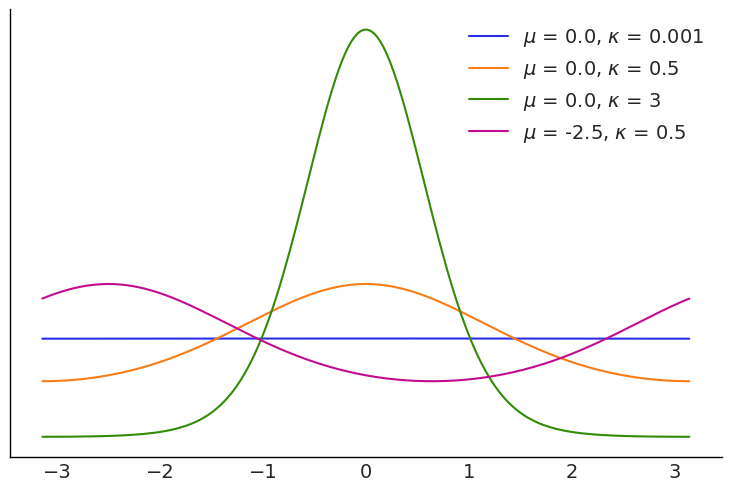

In [3]:
x = np.linspace(-np.pi, np.pi, 200)
mus = [0., 0., 0.,  -2.5]
kappas = [.001, 0.5,  3, 0.5]
for mu, kappa in zip(mus, kappas):
    pdf = stats.vonmises.pdf(x, kappa, loc=mu)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
plt.yticks([])
plt.legend(loc=1);

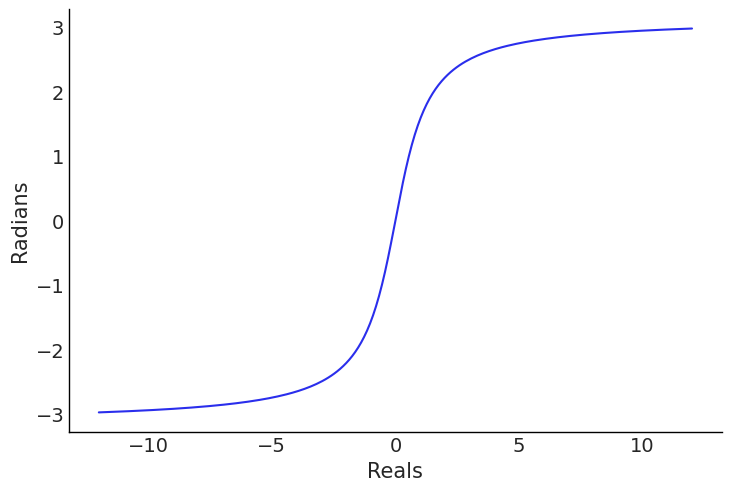

In [4]:
u = np.linspace(-12, 12, 200)
plt.plot(u, 2*np.arctan(u))
plt.xlabel("Reals")
plt.ylabel("Radians");

In [31]:
cirular_reg = '''
functions{
    /* function based of 
    https://github.com/bambinos/bambi/blob/main/bambi/families/link.py
    */
    vector arctan_2(vector eta){
        return 2 * atan(eta);
    }
}
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] beta;       // coefficients for predictors
  real<lower=0> kappa;  // error scale
}
transformed parameters{
vector[N] mu = x * beta;
}
model {
// Priors specifed from defualts of bambi package
beta[1] ~ normal(0, 4.8007);
beta[2:K] ~ normal(0, 0.086);

kappa ~ student_t(4, 0, 1);

y ~ von_mises(arctan_2(mu), kappa);  // likelihood
}
generated quantities{
real yrep[N];
yrep = von_mises_rng(mu, kappa);
}
'''

lin_reg = '''
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
transformed parameters{
vector[N] mu = x * beta;
}
model {
// Priors specifed from defualts of bambi package
beta[1] ~ normal(1.2944, 5.8373);
beta[2:K] ~ normal(0, 0.1046);

sigma ~ student_t(4, 0, 1.2159);

y ~ normal(mu, sigma);  // likelihood
}
generated quantities{
real yrep[N];
yrep = normal_rng(mu, sigma);
}
'''

In [32]:
X = dmatrix(" ~ distance", data=df)
d = {"N": len(df['direction'].values),
     "K": np.shape(X)[1],
     "y": df['direction'].values,
     "x": X}

In [34]:
sm_vm = ps.build(cirular_reg, data = d)
sm_l = ps.build(lin_reg, data = d)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_pdffg27x/model_xtdp4mkp.stan', line 33, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pdffg27x/model_xtdp4mkp.stan', line 26, column 22: Argument
    0.086 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_648tms91/model_axljpd7k.stan', line 25, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [20]:
fit_vm = sm_vm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)
fit_l = sm_l.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:   3% (100/3000)
Sampling:  28% (850/3000)
Sampling:  53% (1600/3000)
Sampling:  78% (2350/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Error in function boost::math::asymptotic_bessel_i_large_x<long double>(long double,long double): Overflow Error (in '/tmp/httpstan_6dmxhg3y/model_72qpkhjs.stan', line 27, column 0 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is

In [30]:
az.summary(fit_vm, var_names = ["beta", "kappa"])
idata_vm = az.from_pystan(posterior=fit_vm, posterior_model=sm_vm, posterior_predictive=['yrep'], observed_data= 'y')
idata_l = az.from_pystan(posterior=fit_l, posterior_model=sm_l, posterior_predictive=['yrep'], observed_data= 'y')

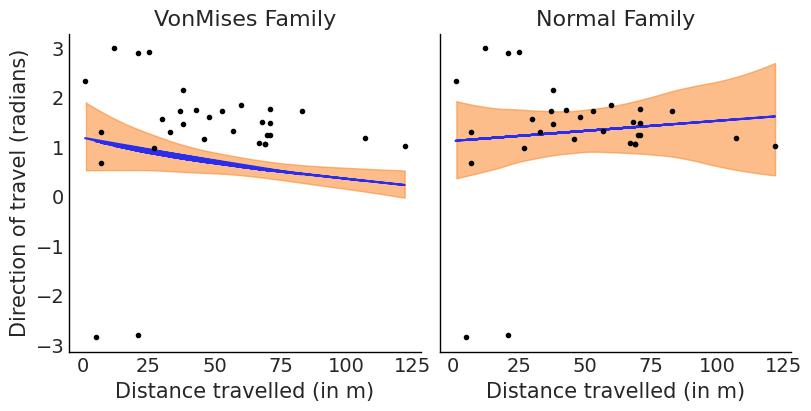

In [12]:
_, ax = plt.subplots(1,2, figsize=(8, 4), sharey=True)
posterior_mean = tan_2(idata_vm.posterior["mu"])
ax[0].plot(df.distance, posterior_mean.mean(("chain", "draw")))
az.plot_hdi(df.distance, posterior_mean, ax=ax[0])

ax[0].plot(df.distance, df.direction, "k.")
ax[0].set_xlabel("Distance travelled (in m)")
ax[0].set_ylabel("Direction of travel (radians)")
ax[0].set_title("VonMises Family")

posterior_mean = idata_l.posterior["mu"]
ax[1].plot(df.distance, posterior_mean.mean(("chain", "draw")))
az.plot_hdi(df.distance, posterior_mean, ax=ax[1])

ax[1].plot(df.distance, df.direction, "k.")
ax[1].set_xlabel("Distance travelled (in m)")
ax[1].set_title("Normal Family");

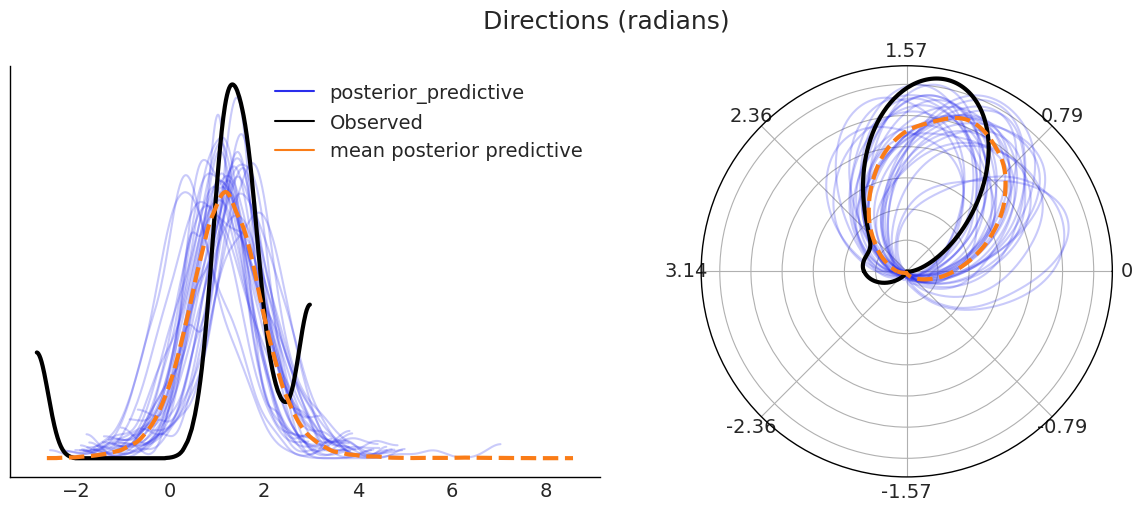

In [29]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121)
ax1 = plt.subplot(122, projection='polar')


pp_samples = az.extract(idata_vm, group="posterior_predictive", num_samples=200)["yrep"]
colors = ["C0" , "k", "C1"]

for ax, circ in zip((ax0, ax1), (False, "radians", colors)):
    for s in pp_samples:
        az.plot_kde(s.values,  plot_kwargs={"color":colors[0], "alpha": 0.25}, is_circular=circ, ax=ax)
    az.plot_kde(idata_vm.observed_data["y"].values,
                plot_kwargs={"color":colors[1], "lw":3}, is_circular=circ, ax=ax)
    az.plot_kde(idata_vm.posterior_predictive["yrep"].values,
                plot_kwargs={"color":colors[2], "ls":"--", "lw":3}, is_circular=circ, ax=ax)

custom_lines = [Line2D([0], [0], color=c) for c in colors]

ax0.legend(custom_lines, ["posterior_predictive", "Observed", 'mean posterior predictive'])
ax0.set_yticks([])
fig.suptitle("Directions (radians)", fontsize=18);

# References

Cremers, J., & Klugkist, I. (2018). One direction? A tutorial for circular data analysis using R with examples in cognitive psychology. Frontiers in psychology, 9, 2040.